# Calculate cosine zenth angle and mean radiant temperature with different approaches

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xclim
import xarray as xr
import numpy as np
import cftime
import dask

In [3]:
def open_xrdataset(files, use_cftime=True, parallel=True, data_vars='minimal', chunks={'time':1}, 
                   coords='minimal', compat='override', drop=None, **kwargs):
    """optimized function for opening large cf datasets.
    based on https://github.com/pydata/xarray/issues/1385#issuecomment-561920115
    decode_timedelta=False is added to leave variables and coordinates with time units in 
    {“days”, “hours”, “minutes”, “seconds”, “milliseconds”, “microseconds”} encoded as numbers.   
    """
    def drop_all_coords(ds):
        return ds.reset_coords(drop=True)

    ds = xr.open_mfdataset(files, parallel=parallel, decode_times=False, combine='by_coords', 
                           preprocess=drop_all_coords, decode_cf=False, chunks=chunks,
                           data_vars=data_vars, coords=coords, compat=compat, **kwargs)

    return xr.decode_cf(ds, use_cftime=use_cftime, decode_timedelta=False)

Read CORDEX **3-hourly** input data.

In [4]:
idir="/pool/data/CORDEX/data/cordex/output/EUR-11/CLMcom/MPI-M-MPI-ESM-LR/rcp26/r1i1p1/CLMcom-BTU-CCLM4-8-17/v1/3hr"
file_str=idir+"/{}/v20180220/{}_EUR-11_MPI-M-MPI-ESM-LR_rcp26_r1i1p1_CLMcom-BTU-CCLM4-8-17_v1_3hr_200601010130-200612312230.nc"
rsds_file = file_str.format("rsds","rsds")
rsus_file = file_str.format("rsus","rsus")
rlds_file = file_str.format("rlds","rlds")
rlus_file = file_str.format("rlus","rlus")
rsds = open_xrdataset(rsds_file).rsds
rsus = open_xrdataset(rsus_file).rsus
rlds = open_xrdataset(rlds_file).rlds
rlus = open_xrdataset(rlus_file).rlus

In [5]:
rsds0101 = rsds.sel(time="20060101").compute()
rsus0101 = rsus.sel(time="20060101").compute()
rlds0101 = rlds.sel(time="20060101").compute()
rlus0101 = rlus.sel(time="20060101").compute()

Define some functions to calculate cosine zenith angle during each interval and during the sunlit period of each interval. Taken from **PyWBGT**.

In [6]:
from xclim.indices.helpers import solar_declination
from xclim.core.calendar import datetime_to_decimal_year

In [7]:
def get_hours(dates):
    return ((dates - dates.dt.floor("D")).dt.seconds / 3600).assign_attrs(units="h")

In [8]:
def calculate_dayangle(dates):
    hours = get_hours(dates)
    decimal_year = datetime_to_decimal_year(times=dates, calendar=dates.dt.calendar)
    return ((decimal_year % 1) * 2 * np.pi).assign_attrs(units="rad")

In [9]:
def calculate_hourangle(hours, lon):
    """
    Hour angle
    
    Parameters
    ----------
    hours : xr.DataArray
        Hours of the Datetime 
    lon : xr.DataArray
        Longitude [deg]
        
    Returns
    -------
    xr.DataArray
        Hour angle [rad]
        
    Notes
    -----
    https://github.com/QINQINKONG/PyWBGT/blob/v1.0.0/src/coszenith.pyx#L45-L55
    """
    sharad = ((hours - 12) * 15 + lon) * np.pi / 180
    sharad = xr.where(sharad>=np.pi, sharad - 2 * np.pi, sharad)
    sharad = xr.where(sharad<-np.pi, sharad + 2 * np.pi, sharad)
    return sharad

In [10]:
def calculate_hourstart(hourangle, interval):
    """
    Hour angle of the starting point of each interval
    
    Parameters
    ----------
    hourangle : xr.DataArray
        Hour angle [rad]
    interval : int    
        Time interval between two time steps [hours]
        
    Returns
    -------
    xr.DataArray
        Hour angle of the starting point of each interval
        
    Notes
    -----
    https://github.com/QINQINKONG/PyWBGT/blob/v1.0.0/src/coszenith.pyx#L57-L68
    """
    k = interval / 2.0
    hs1 = hourangle - k * 15 * np.pi / 180
    hs2 = hourangle + k * 15 * np.pi / 180
    hstart = xr.where(hs1 < -np.pi, hs1 + 2 * np.pi, hs1)
    hstart = xr.where(hs2 >= np.pi, hs1, hstart)
    return hstart

def calculate_hourend(hourangle, interval):
    """
    Hour angle of the end point of each interval
    
    Parameters
    ----------
    hourangle : xr.DataArray
        Hour angle [rad]
    interval : int    
        Time interval between two time steps [hours]
        
    Returns
    -------
    xr.DataArray
        Hour angle of the end point of each interval [rad]
        
    Notes
    -----
    https://github.com/QINQINKONG/PyWBGT/blob/v1.0.0/src/coszenith.pyx#L70-L81
    """    
    k = interval / 2.0
    he1 = hourangle + k * 15 * np.pi / 180
    he2 = hourangle - k * 15 * np.pi / 180
    hend = xr.where(he2 < -np.pi, he1, he1)
    hend = xr.where(he1 >= np.pi, he1 - 2 * np.pi, hend)
    return hend 

In [11]:
def get_cza_parameters(time, lon, lat, sunlit=None):
    """
    Parameter dictionary for calculating both cosine zenith angle during each interval 
    and during the sunlit period of each interval
    
    Parameters
    ----------
    time : xr.DataArray
        Time series
    lon : xr.DataArray
        Longitude [deg]
    lat : xr.DataArray
        Latitude [deg]
    sunlit : bool, optional
        If True calculate both the hour of sunrise and sunset too
        
    Returns
    -------
    dict
        Parameter dictionary for calculating cosine zenith angle
        
    Notes
    -----
    e.g. https://github.com/QINQINKONG/PyWBGT/blob/v1.0.0/src/coszenith.pyx#L176-L205
    """      
    param_dict = {"hour_sunrise" : None, 
                  "hour_sunset" : None}
    hours = get_hours(time)
    grad = calculate_dayangle(time)
    drad = solar_declination(grad)
    latrad = lat * np.pi / 180
    hour_angle = calculate_hourangle(hours, lon)
    interval = (time.diff("time").dt.seconds / 3600).reindex(
        time=time.time, method="bfill"
    )
    param_dict["hour_start"] = calculate_hourstart(hour_angle, interval)
    param_dict["hour_end"] = calculate_hourend(hour_angle, interval)
    param_dict["interval"] = interval
    param_dict["sindec_sinlat"] = np.sin(drad) * np.sin(latrad)
    param_dict["cosdec_coslat"] = cosdec_coslat = np.cos(drad) * np.cos(latrad)
    param_dict["latrad_drad"] = latrad * drad
    
    if sunlit is True:
        arg = -np.tan(drad) * np.tan(latrad)
        """
        https://github.com/QINQINKONG/PyWBGT/blob/v1.0.0/src/coszenith.pyx#L237-L238  
        """
        param_dict["hour_sunrise"] = -np.arccos(arg)
        param_dict["hour_sunset"] = np.arccos(arg)

    return param_dict

In [12]:
def cza(sindec_sinlat, cosdec_coslat, hmin, hmax, interval=None):
    """
    Function 1 to calcualte cosine zenith angle
    
    Parameters
    ----------
    sindec_sinlat : xr.DataArray
        Product of the sine of solar declination [rad] and 
        the sine of latitudes [rad]
    cosdec_coslat : xr.DataArray
        Product of the cosine of solar declination [rad] and 
        the cosine of latitudes [rad]
    hmin : xr.DataArray
        Minimum hour angle [rad]
    hmax : xr.DataArray
        Maximum hour angle [rad]
    interval : int, optional
        Time interval between two time steps [hours]
        
    Returns
    -------
    xr.DataArray
        Cosine of zenith angle
    
    Notes
    -----
    e.g. https://github.com/QINQINKONG/PyWBGT/blob/v1.0.0/src/coszenith.pyx#L140
    """    
    if interval is None:
        denominator = hmax - hmin
    else:
        denominator = interval*15.0/180.0*np.pi
    return (
        sindec_sinlat
        + cosdec_coslat
        * (np.sin(hmax) - np.sin(hmin))
        * ((denominator) ** (-1))
    )

In [13]:
def cza2(sindec_sinlat, cosdec_coslat, hmin1, hmin2, hmax1, hmax2):
    """
    Function 2 to calcualte cosine zenith angle
    
    Parameters
    ----------
    sindec_sinlat : xr.DataArray
        Product of the sine of solar declination [rad] and 
        the sine of latitudes [rad]
    cosdec_coslat : xr.DataArray
        Product of the cosine of solar declination [rad] and 
        the cosine of latitudes [rad]
    hmin1 : xr.DataArray
        First minimum hour angle [rad]
    hmin2 : xr.DataArray
        Second minimum hour angle [rad]       
    hmax1 : xr.DataArray
        First maximum hour angle [rad]
    hmax2 : xr.DataArray
        First maximum hour angle [rad]       
    interval : int, optional
        Time interval between two time steps [hours]
        
    Returns
    -------
    xr.DataArray
        Cosine of zenith angle
    
    Notes
    -----    
    e.g. https://github.com/QINQINKONG/PyWBGT/blob/v1.0.0/src/coszenith.pyx#L136
    """      
    return (
            sindec_sinlat
            * (hmax1 - hmin1)
            + cosdec_coslat
            * (np.sin(hmax1) - np.sin(hmin1))
            + sindec_sinlat
            * (hmax2 - hmin2)
            + cosdec_coslat
            * (np.sin(hmax2) - np.sin(hmin2))
            *((hmax1 - hmin1 + hmax2 - hmin2) ** (-1))
        )

In [14]:
def calculate_czai(hour_start, 
                   hour_end, 
                   sindec_sinlat, 
                   cosdec_coslat, 
                   **kwargs):
    """
    Cosine zenith angle during each interval
    
    Parameters
    ----------
    hour_start : xr.DataArray
        Hour angle at the starting point of each interval  [rad]
    hour_end : xr.DataArray
        Hour angle at the end point of each interval  [rad]
    sindec_sinlat :  xr.DataArray
        Product of the sine of solar declination [rad] and 
        the sine of latitudes [rad]
    cosdec_coslat : xr.DataArray
        Product of the cosine of solar declination [rad] and 
        the cosine of latitudes [rad]
        
    Returns
    -------
    xr.DataArray
        Cosine zenith angle during each interval [rad]
        
    Notes
    -----
    https://github.com/QINQINKONG/PyWBGT/blob/v1.0.0/src/coszenith.pyx#L123-L141
    """    
    c0 = cza(sindec_sinlat,
             cosdec_coslat,
             hmin=hour_start,
             hmax=hour_end)
    
    c1 = cza2(sindec_sinlat,
              cosdec_coslat,
              hmin1=hour_start,
              hmin2=-np.pi,
              hmax1=np.pi,
              hmax2=hour_end)
    czai = xr.where((hour_start > 0) & (hour_end < 0), c1, c0)      
    return czai

In [15]:
def calculate_czas(hour_start, 
                   hour_end, 
                   hour_sunrise, 
                   hour_sunset, 
                   sindec_sinlat, 
                   cosdec_coslat, 
                   latrad_drad, 
                   interval):
    """
    Cosine zenith angle during the sunlit period of each interval
    
    Parameters
    ----------
    hour_start : xr.DataArray
        Hour angle at the starting point of each interval  [rad]
    hour_end : xr.DataArray
        Hour angle at the end point of each interval  [rad]
    hour_sunrise : xr.DataArray
        Hour angle at sunrise [rad]
    hour_sunset : xr.DataArray
        Hour angle at sunset [rad]
    sindec_sinlat :  xr.DataArray
        Product of the sine of solar declination [rad] and 
        the sine of latitudes [rad]
    cosdec_coslat : xr.DataArray
        Product of the cosine of solar declination [rad] and 
        the cosine of latitudes [rad]
    latrad_drad : xr.DataArray
        Product od latitudes [rad] and solar declination [rad]
    interval : int, optional
        Time interval between two time steps [hours]
        
    Returns
    -------
    xr.DataArray
        Cosine zenith angle during the sunlit period of each interval [rad]
        
    Notes
    -----    
    https://github.com/QINQINKONG/PyWBGT/blob/v1.0.0/src/coszenith.pyx#L84-L120
    """
    c0 = cza(sindec_sinlat,
             cosdec_coslat,
             hmin=xr.where(hour_sunrise>hour_start, hour_sunrise, hour_start),
             hmax=xr.where(hour_sunset<hour_end, hour_sunset, hour_end))
    
    c1 = cza2(sindec_sinlat, 
              cosdec_coslat, 
              hmin1=hour_start, 
              hmin2=hour_sunrise, 
              hmax1=hour_sunset, 
              hmax2=hour_end)
        
    c2 = cza(sindec_sinlat, 
             cosdec_coslat, 
             hmin=hour_start, 
             hmax=hour_sunset) 
        
    c3 = cza(sindec_sinlat, 
             cosdec_coslat, 
             hmin=hour_sunrise, 
             hmax=hour_end) 
        
    c4 = 0
        
    c5 = 0
        
    c6 = cza(sindec_sinlat, 
             cosdec_coslat, 
             hmin=hour_start, 
             hmax=hour_end, 
             interval=interval)
        
    czas = xr.where((hour_start > 0) 
                    & (hour_start < hour_sunset) 
                    & (hour_end < 0) 
                    & (hour_end > hour_sunrise), c1, c0)
    czas = xr.where((hour_start > 0) 
                    & (hour_start < hour_sunset) 
                    & (hour_end < hour_sunrise), c2, czas)
    czas = xr.where((hour_start > hour_sunset) 
                    & (hour_end < 0) 
                    & (hour_end > hour_sunrise), c3, czas)
    czas = xr.where(((hour_start > hour_sunset) 
                     & (hour_end < hour_sunrise)) 
                    | 
                    ((hour_start < hour_sunrise) 
                     & (hour_end < hour_sunrise)) 
                    | 
                    ((hour_start > hour_sunset) 
                     & (hour_end > hour_sunset)), c4, czas)
    czas = xr.where((np.isnan(hour_sunrise)) 
                    & (latrad_drad < 0), c5, czas)   
    czas = xr.where((np.isnan(hour_sunrise)) 
                    & (latrad_drad > 0), c6, czas)
    return czas

In [16]:
def calculate_cosine_zenith_angle_interval(time, lon, lat):
    """
    Cosine zenith angle during each interval
    
    Parameters
    ----------
    time : xr.DataArray
        Time series
    lon : xr.DataArray
        Longitudes [rad]
    lat : xr.DataArray
        Latitudes [rad]
        
    Returns
    -------
    xr.DataArray
        Cosine zenith angle during each interval [rad]
    """
    param_dict = get_cza_parameters(time, lon, lat)
    czai = calculate_czai(**param_dict)
    return np.clip(czai, 0, None)

In [17]:
def calculate_cosine_zenith_angle_sunlit(time, lon, lat):
    """
    Cosine zenith angle during the sunlit period of each interval
    
    Parameters
    ----------
    time : xr.DataArray
        Time series
    lon : xr.DataArray
        Longitudes [rad]
    lat : xr.DataArray
        Latitudes [rad]
        
    Returns
    -------
    xr.DataArray
        Cosine zenith angle during the sunlit period of each interval [rad]
    """    
    param_dict = get_cza_parameters(time, lon, lat, sunlit=True)
    czas = calculate_czas(**param_dict)
    return np.clip(czas, 0, None)

Now, let's calculate both the cosine zenith angle during each interval and during the sunlit of each interval using 3-hourly input data.

In [18]:
czai_3hr = calculate_cosine_zenith_angle_interval(rsds0101.time, rsds0101.lon, rsds0101.lat)

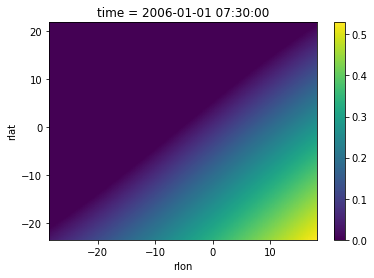

In [19]:
czai_3hr.isel(time=2).plot()

In [20]:
czas_3hr = calculate_cosine_zenith_angle_sunlit(rsds0101.time, rsds0101.lon, rsds0101.lat)

/home/g/g300100/.conda/envs/xclim/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in arccos
  result_data = func(*input_data)
/home/g/g300100/.conda/envs/xclim/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in arccos
  result_data = func(*input_data)


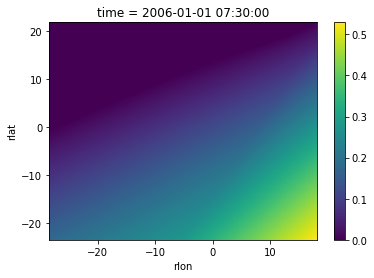

In [21]:
czas_3hr.isel(time=2).plot()

Plot the difference of those two angles.

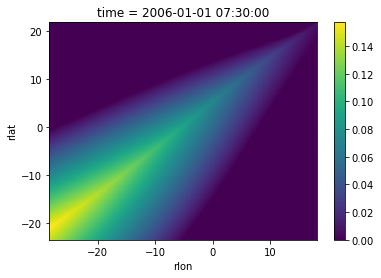

In [22]:
(czas_3hr.isel(time=2) - czai_3hr.isel(time=2)).plot()

We need some more functions to calculate the ratio of direct solar radiation (fdir_ratio)

In [23]:
from xclim.indices.helpers import distance_from_sun
from xclim.indices._conversion import _fdir_ratio

Now we can calcualte the ratio of direct solar radiation from both cosine zenith angles and `rsds` (Surface Downwelling Shortwave Radiation)

In [24]:
fdir_ratio = _fdir_ratio(rsds0101.time, czai_3hr, czas_3hr, rsds0101)

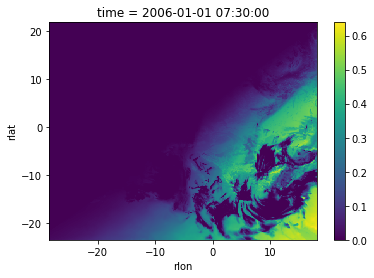

In [25]:
fdir_ratio.isel(time=2).plot()

And now, we define the mean radiant temperature.

In [26]:
def mean_radiant_temperature(rsds, 
                             rsus, 
                             rlds, 
                             rlus, 
                             fdir_ratio=None, 
                             czai=None, 
                             czas=None):
    """
    Mean radiant temeprature
    
    Parameters
    ----------
    rsds : xr.DataArray
       Surface Downwelling Shortwave Radiation [W m-2] 
    rsus : xr.DataArray
        Surface Upwelling Shortwave Radiation [W m-2]
    rlds : xr.DataArray
        Surface Downwelling Longwave Radiation [W m-2]
    rlus : xr.DataArray
        Surface Upwelling Longwave Radiation [W m-2]
    fdir_ratio : xr.DataArray, optional
        Ratio of Direct Solar Radiation []
    czai : xr.DataArray, optional
        Cosine Zenith Angle during each interval [rad]
    czas : xr.DataArray, optional
        Cosine Zenith Angle during the sunlit period of each interval [rad]
    
    Returns
    -------
    xr.DataArray
        Mean Radiant Temperature [K]
    
    Notes
    -----
    https://github.com/ecmwf-projects/thermofeel/blob/master/thermofeel/thermofeel.py#L309-L349
    """
    time=rsds.time
    lat=rsds.lat
    lon=rsds.lon
    if czai is None:
        czai = calculate_cosine_zenith_angle_interval(time, lon, lat)
    if czas is None:
        czas = calculate_cosine_zenith_angle_sunlit(time, lon, lat)
    if fdir_ratio is None:
        fdir_ratio = _fdir_ratio(time, czai, czas, rsds)
        
    rsds_direct  = fdir_ratio * rsds
    rsds_diffuse = rsds - rsds_direct

    gamma = np.arcsin(czai)
    fp = 0.308 * np.cos(gamma * 0.998 - (gamma ** 2 / 50000))
    
    i_star = xr.where(czas > 0.01, rsds_direct / czas, 0)
    
    # calculate mean radiant temperature
    return np.power(
        (
            (1 / 5.67e-8)
            * (
                0.5 * rlds
                + 0.5 * rlus
                + (0.7 / 0.97) * (0.5 * rsds_diffuse + 0.5 * rsus + fp * i_star)
            )
        ),
        0.25,
            
    )

Let's calculate the mean radiant temperature `MRT` from `rsds`, `rsus`, `rlds`, `rlus`, both cosine zeniht angles (`czai` and `czas`) and `fdir_ratio`.

In [27]:
mrt1 = mean_radiant_temperature(rsds0101, 
                                rsus0101, 
                                rlds0101, 
                                rlus0101, 
                                czai=czai_3hr, 
                                czas=czas_3hr,
                                fdir_ratio=fdir_ratio)

Are thera any weird glitches?

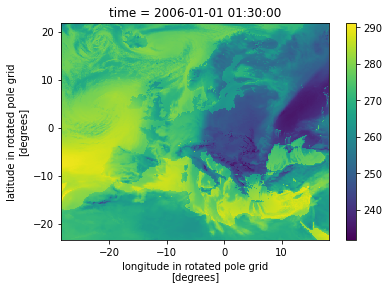

In [28]:
mrt1.isel(time=0).plot()

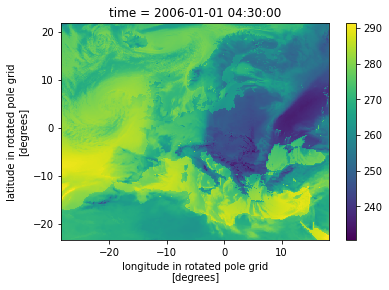

In [29]:
mrt1.isel(time=1).plot()

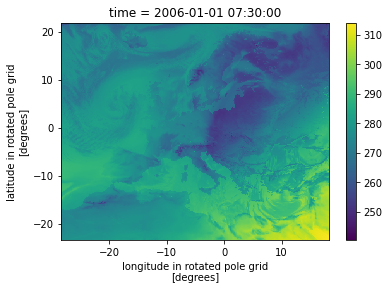

In [30]:
mrt1.isel(time=2).plot()

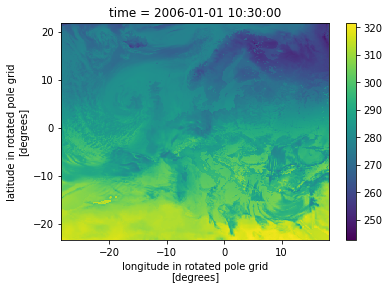

In [31]:
mrt1.isel(time=3).plot()

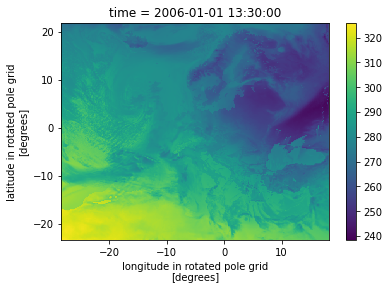

In [32]:
mrt1.isel(time=4).plot()

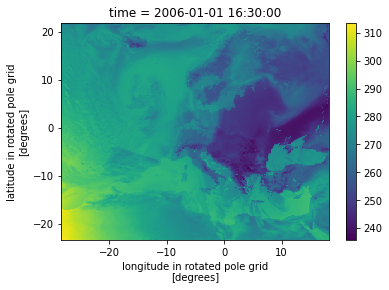

In [33]:
mrt1.isel(time=5).plot()

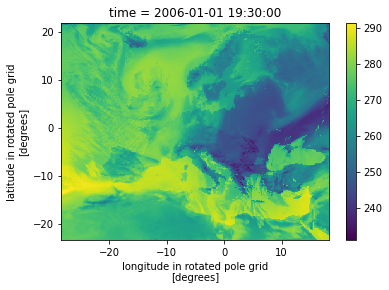

In [34]:
mrt1.isel(time=6).plot()

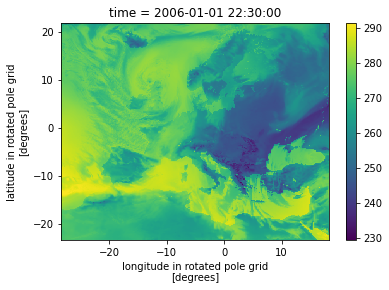

In [35]:
mrt1.isel(time=7).plot()

That's not the case. Now, calcualte `mrt` from the simplier xclim approach

In [36]:
from xclim.indicators.atmos import mean_radiant_temperature as mean_radiant_temperature_xclim

In [37]:
mrt_xclim = mean_radiant_temperature_xclim(rsds0101, 
                                           rsus0101, 
                                           rlds0101, 
                                           rlus0101, 
                                           stat="sunlit")

/home/g/g300100/.conda/envs/xclim/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in arccos
  result_data = func(*input_data)
/home/g/g300100/.conda/envs/xclim/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in arccos
  result_data = func(*input_data)
/home/g/g300100/.conda/envs/xclim/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in arccos
  result_data = func(*input_data)
/home/g/g300100/.conda/envs/xclim/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in arccos
  result_data = func(*input_data)


Let's have a look if we now find weird glitches.

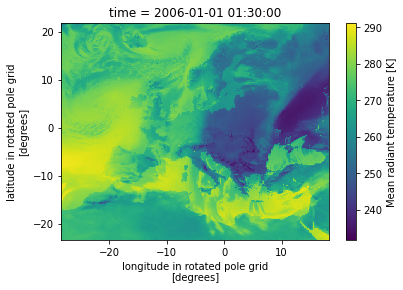

In [38]:
mrt_xclim.isel(time=0).plot()

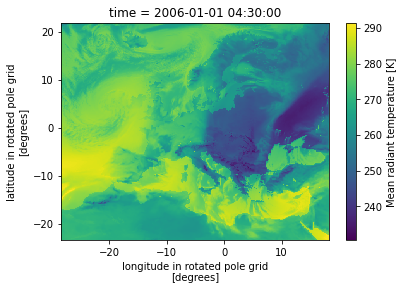

In [39]:
mrt_xclim.isel(time=1).plot()

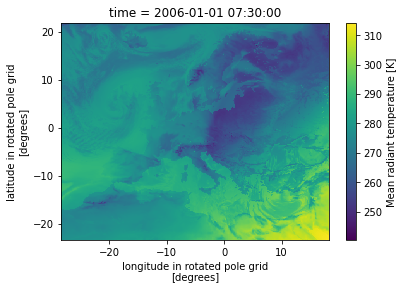

In [40]:
mrt_xclim.isel(time=2).plot()

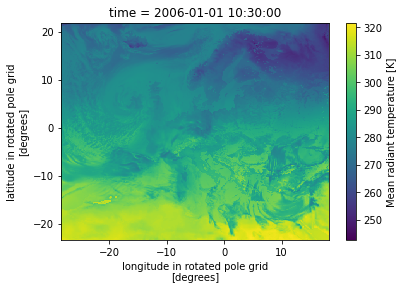

In [41]:
mrt_xclim.isel(time=3).plot()

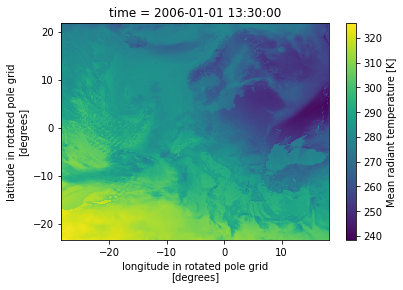

In [42]:
mrt_xclim.isel(time=4).plot()

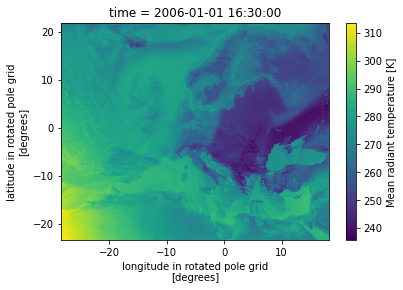

In [43]:
mrt_xclim.isel(time=5).plot()

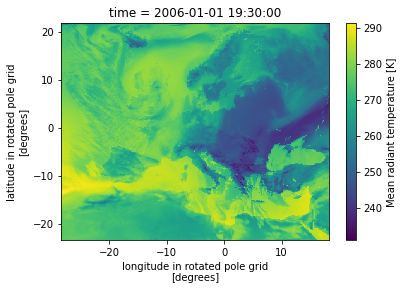

In [44]:
mrt_xclim.isel(time=6).plot()

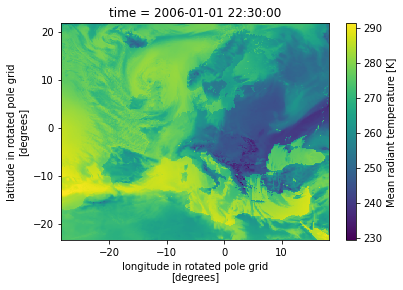

In [45]:
mrt_xclim.isel(time=7).plot()

Luckily, that's not the case. What is the difference between those two approaches?

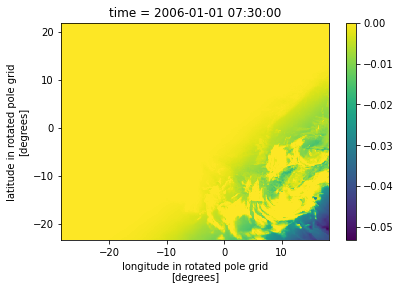

In [46]:
(mrt1 - mrt_xclim).isel(time=2).plot()

The differnce is pretty small. Let's have a look at another region **NAM**.

In [47]:
idir="/pool/data/CORDEX/data/cordex/output/NAM-22/GERICS/MPI-M-MPI-ESM-LR/rcp26/r1i1p1/GERICS-REMO2015/v1/3hr"
file_str=idir+"/{}/v20191025/{}_NAM-22_MPI-M-MPI-ESM-LR_rcp26_r1i1p1_GERICS-REMO2015_v1_3hr_200601010130-200612312230.nc"
rsds_file = file_str.format("rsds","rsds")
rsus_file = file_str.format("rsus","rsus")
rlds_file = file_str.format("rlds","rlds")
rlus_file = file_str.format("rlus","rlus")
rsds2 = open_xrdataset(rsds_file).rsds
rsus2 = open_xrdataset(rsus_file).rsus
rlds2 = open_xrdataset(rlds_file).rlds
rlus2 = open_xrdataset(rlus_file).rlus

In [48]:
rsds20101 = rsds2.sel(time="20060101").compute()
rsus20101 = rsus2.sel(time="20060101").compute()
rlds20101 = rlds2.sel(time="20060101").compute()
rlus20101 = rlus2.sel(time="20060101").compute()

During the sunlit period of each interval:

In [49]:
mrt_xclim_NAM_sun = mean_radiant_temperature_xclim(rsds20101, 
                                                   rsus20101, 
                                                   rlds20101, 
                                                   rlus20101, 
                                                   stat="sunlit")

/home/g/g300100/.conda/envs/xclim/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in arccos
  result_data = func(*input_data)
/home/g/g300100/.conda/envs/xclim/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in arccos
  result_data = func(*input_data)
/home/g/g300100/.conda/envs/xclim/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in arccos
  result_data = func(*input_data)
/home/g/g300100/.conda/envs/xclim/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in arccos
  result_data = func(*input_data)


Instantaneous values:

In [50]:
mrt_xclim_NAM_ins = mean_radiant_temperature_xclim(rsds20101, 
                                                   rsus20101, 
                                                   rlds20101, 
                                                   rlus20101, 
                                                   stat="instant")

/home/g/g300100/.conda/envs/xclim/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in arccos
  result_data = func(*input_data)
/home/g/g300100/.conda/envs/xclim/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in arccos
  result_data = func(*input_data)


Average over each period:

In [51]:
mrt_xclim_NAM_avg = mean_radiant_temperature_xclim(rsds20101, 
                                                   rsus20101, 
                                                   rlds20101, 
                                                   rlus20101, 
                                                   stat="average")

/home/g/g300100/.conda/envs/xclim/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in arccos
  result_data = func(*input_data)
/home/g/g300100/.conda/envs/xclim/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in arccos
  result_data = func(*input_data)


And now, let's plot.

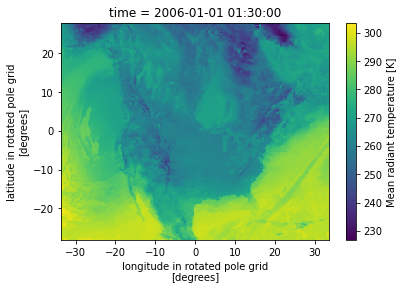

In [52]:
mrt_xclim_NAM_sun.isel(time=0).plot()

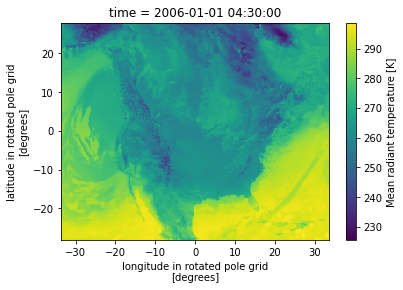

In [53]:
mrt_xclim_NAM_sun.isel(time=1).plot()

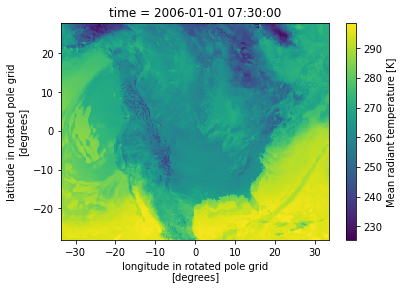

In [54]:
mrt_xclim_NAM_sun.isel(time=2).plot()

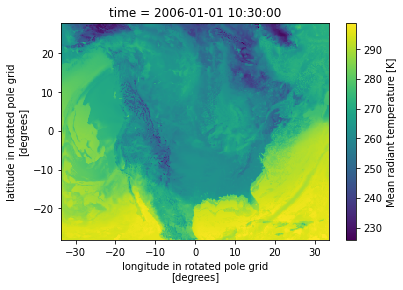

In [55]:
mrt_xclim_NAM_sun.isel(time=3).plot()

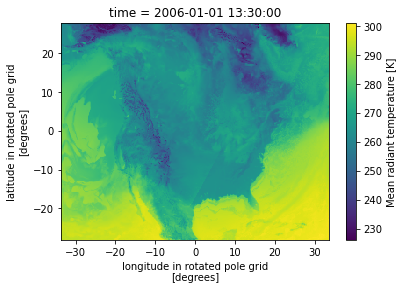

In [56]:
mrt_xclim_NAM_sun.isel(time=4).plot()

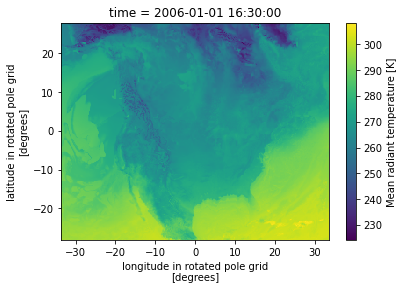

In [57]:
mrt_xclim_NAM_sun.isel(time=5).plot()

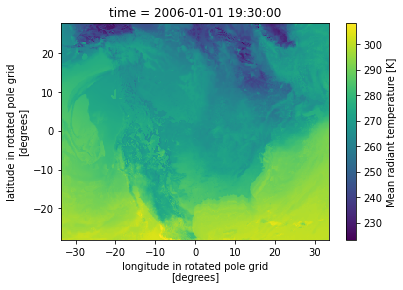

In [58]:
mrt_xclim_NAM_sun.isel(time=6).plot()

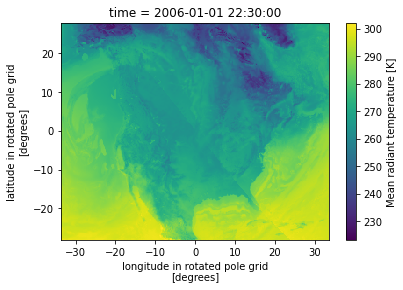

In [59]:
mrt_xclim_NAM_sun.isel(time=7).plot()

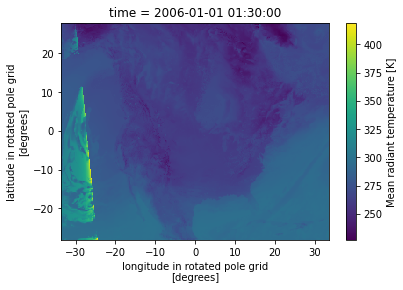

In [60]:
mrt_xclim_NAM_ins.isel(time=0).plot()

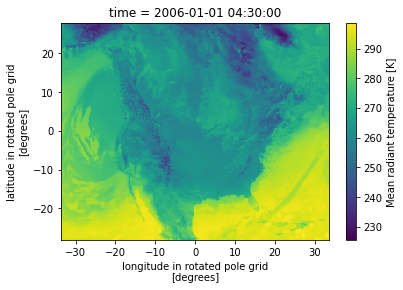

In [61]:
mrt_xclim_NAM_ins.isel(time=1).plot()

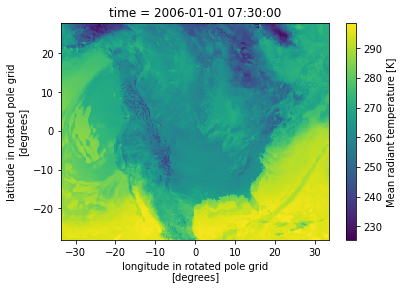

In [62]:
mrt_xclim_NAM_ins.isel(time=2).plot()

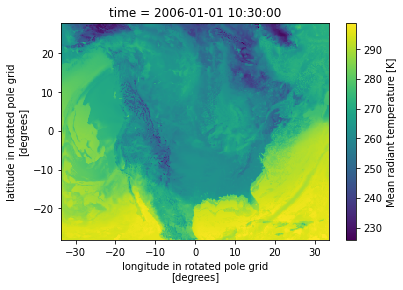

In [63]:
mrt_xclim_NAM_ins.isel(time=3).plot()

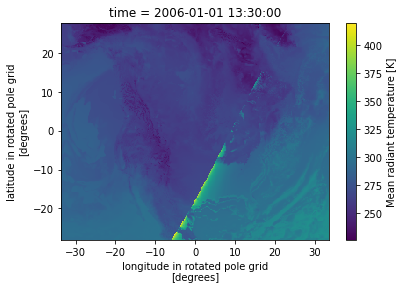

In [64]:
mrt_xclim_NAM_ins.isel(time=4).plot()

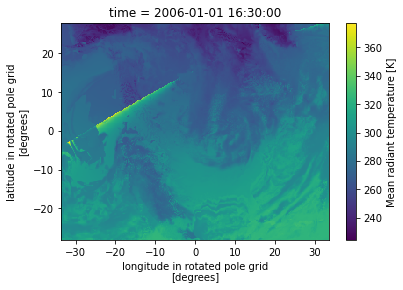

In [65]:
mrt_xclim_NAM_ins.isel(time=5).plot()

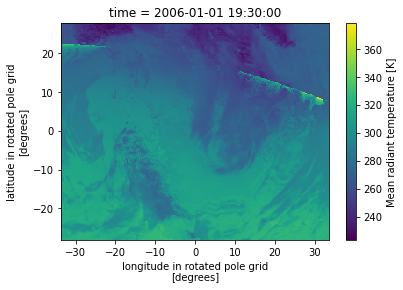

In [66]:
mrt_xclim_NAM_ins.isel(time=6).plot()

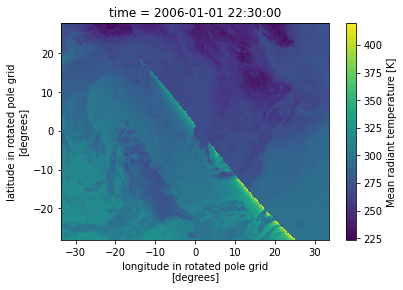

In [67]:
mrt_xclim_NAM_ins.isel(time=7).plot()

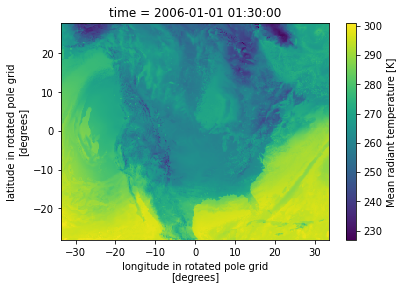

In [68]:
mrt_xclim_NAM_avg.isel(time=0).plot()

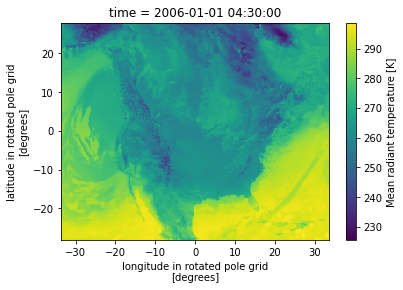

In [69]:
mrt_xclim_NAM_avg.isel(time=1).plot()

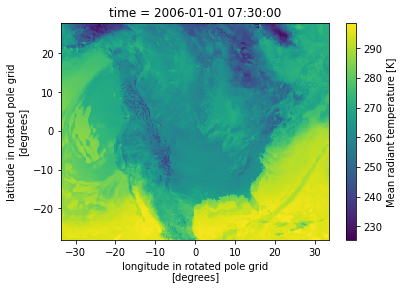

In [70]:
mrt_xclim_NAM_avg.isel(time=2).plot()

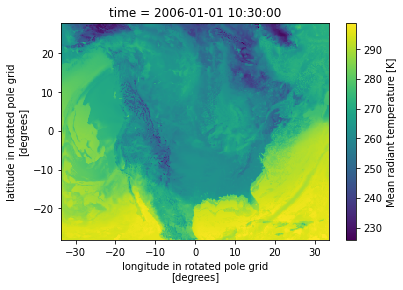

In [71]:
mrt_xclim_NAM_avg.isel(time=3).plot()

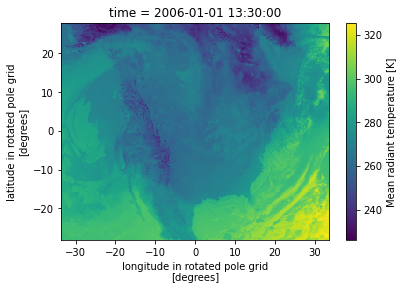

In [72]:
mrt_xclim_NAM_avg.isel(time=4).plot()

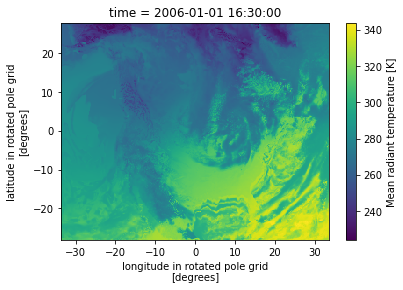

In [73]:
mrt_xclim_NAM_avg.isel(time=5).plot()

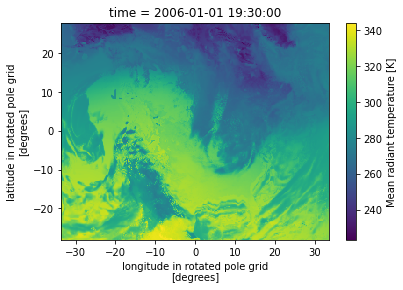

In [74]:
mrt_xclim_NAM_avg.isel(time=6).plot()

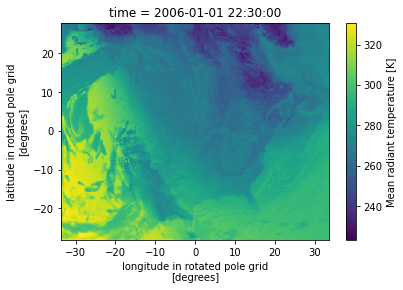

In [75]:
mrt_xclim_NAM_avg.isel(time=7).plot()

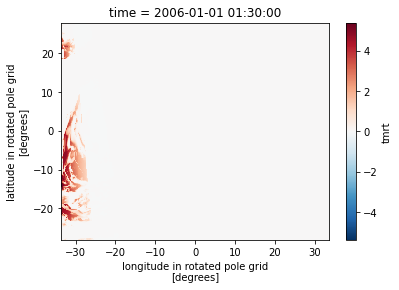

In [76]:
(mrt_xclim_NAM_sun - mrt_xclim_NAM_avg).isel(time=0).plot()

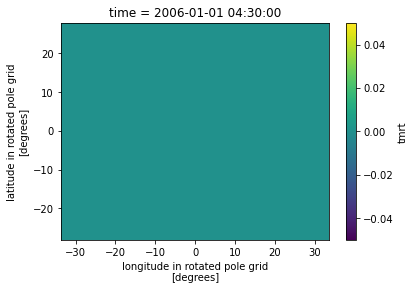

In [77]:
(mrt_xclim_NAM_sun - mrt_xclim_NAM_avg).isel(time=1).plot()

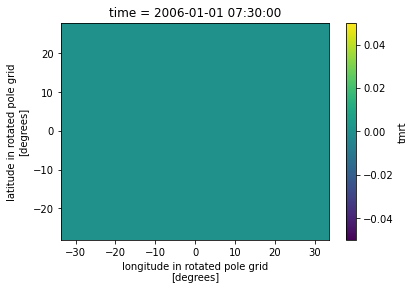

In [78]:
(mrt_xclim_NAM_sun - mrt_xclim_NAM_avg).isel(time=2).plot()

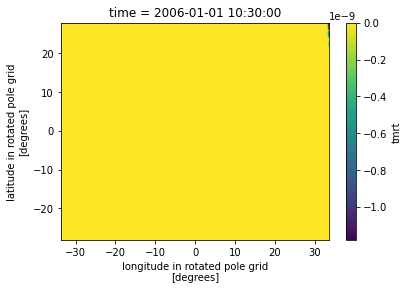

In [79]:
(mrt_xclim_NAM_sun - mrt_xclim_NAM_avg).isel(time=3).plot()

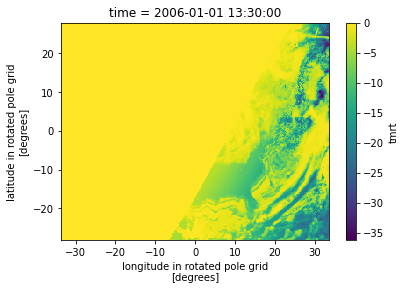

In [80]:
(mrt_xclim_NAM_sun - mrt_xclim_NAM_avg).isel(time=4).plot()

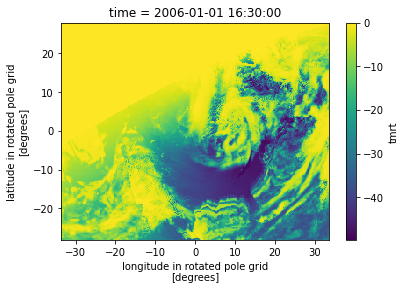

In [81]:
(mrt_xclim_NAM_sun - mrt_xclim_NAM_avg).isel(time=5).plot()

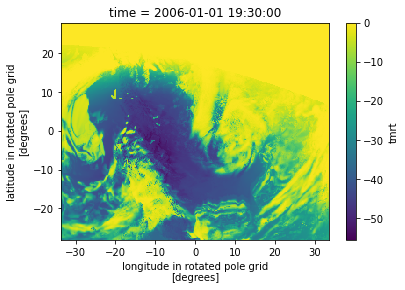

In [82]:
(mrt_xclim_NAM_sun - mrt_xclim_NAM_avg).isel(time=6).plot()

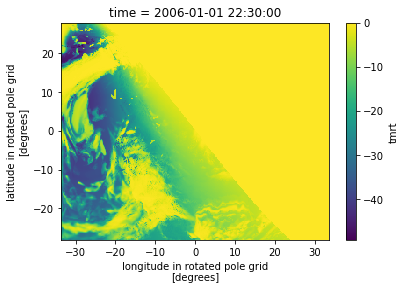

In [83]:
(mrt_xclim_NAM_sun - mrt_xclim_NAM_avg).isel(time=7).plot()

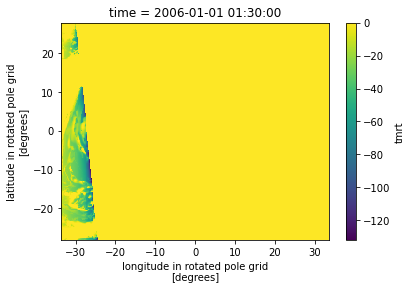

In [84]:
(mrt_xclim_NAM_sun - mrt_xclim_NAM_ins).isel(time=0).plot()

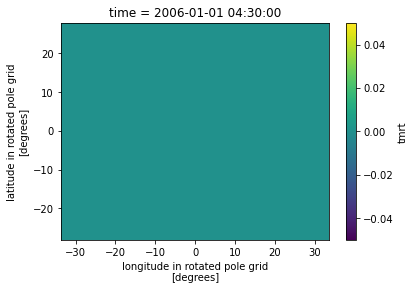

In [85]:
(mrt_xclim_NAM_sun - mrt_xclim_NAM_ins).isel(time=1).plot()

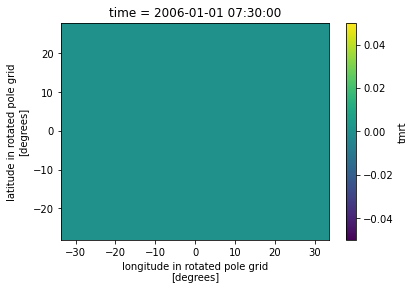

In [86]:
(mrt_xclim_NAM_sun - mrt_xclim_NAM_ins).isel(time=2).plot()

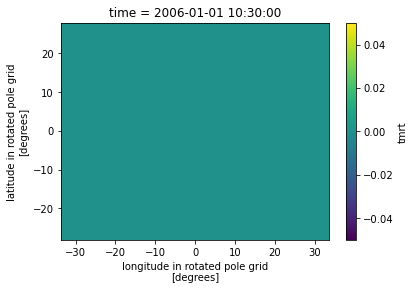

In [87]:
(mrt_xclim_NAM_sun - mrt_xclim_NAM_ins).isel(time=3).plot()

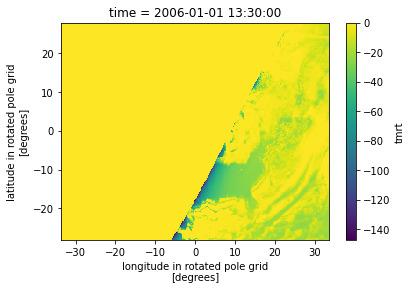

In [88]:
(mrt_xclim_NAM_sun - mrt_xclim_NAM_ins).isel(time=4).plot()

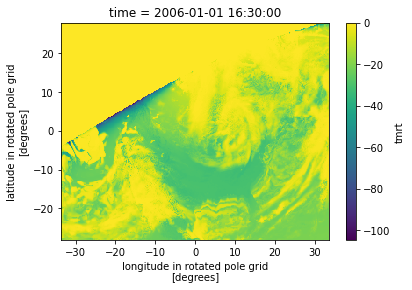

In [89]:
(mrt_xclim_NAM_sun - mrt_xclim_NAM_ins).isel(time=5).plot()

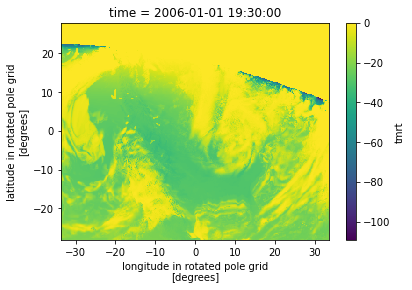

In [90]:
(mrt_xclim_NAM_sun - mrt_xclim_NAM_ins).isel(time=6).plot()

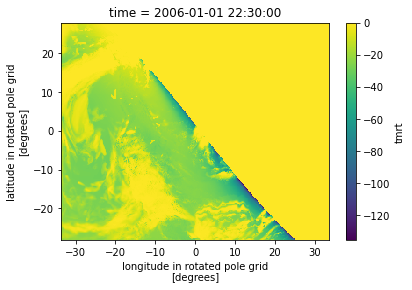

In [91]:
(mrt_xclim_NAM_sun - mrt_xclim_NAM_ins).isel(time=7).plot()